# Clustering

This notebook implements kmeans in pytorch the goal is to vectorize kmeans as much as possible. This is a part of lecture 12 mean shift cluster fast ai course. <br>
Kmneas implementation follows [amazing blog post](https://www.gaohongnan.com/influential/kmeans_clustering/02_concept.html) by Mr. Gao Hongnan.

In [26]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
import random
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [5]:
n_clusters=6
n_samples =250
centroids = torch.rand(n_clusters, 2)*70-35
centroids
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor
torch.tensor([[5.,2.5],[2.5,5.]])
torch.diag(tensor([5.,5.]))
def sample(m): return MultivariateNormal(m, torch.tensor([[15.,7.5],[7.5,15.]])).sample((n_samples,))

slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])


* c => all points in the cluster
* v => cluster centers 


## Thought process

In [ ]:
X = data.clone()

In [ ]:
k = 6
v = X[torch.randint(X.shape[0],(6,))]

In [ ]:
point_center_dist = (v[:,None] - X ).norm(2, dim=2);point_center_dist

tensor([[51.421, 56.831, 58.502,  ..., 37.752, 28.506, 32.103],
        [38.041, 37.859, 46.269,  ..., 44.642, 45.620, 47.037],
        [44.493, 46.378, 54.341,  ..., 45.493, 42.691, 45.737],
        [19.999, 25.386, 26.324,  ...,  5.644,  4.822,  0.077],
        [33.905, 31.732, 39.643,  ..., 44.561, 48.410, 48.424],
        [20.630, 26.051, 27.503,  ...,  6.717,  3.055,  1.841]], device='cuda:0')

In [976]:
cluster_assigment = point_center_dist.argmin(0); cluster_assigment

tensor([3, 3, 3,  ..., 3, 5, 3], device='cuda:0')

In [977]:
cluster_binary_mask = torch.nn.functional.one_hot(cluster_assigment, num_classes=k).type(torch.float)

In [978]:
torch.zeros(cluster_assigment.size(0), k).cuda().scatter_(1, cluster_assigment[...,None], 1)

tensor([[0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.]], device='cuda:0')

In [ ]:
X.T.shape, cluster_binary_mask.shape

(torch.Size([2, 1500]), torch.Size([1500, 6]))

In [ ]:
(cluster_binary_mask.T @ X) 

tensor([[ 7749.357, -6310.159],
        [-4693.570,  6727.239],
        [-2106.970,  1568.401],
        [11244.857,  8378.818],
        [-1344.559,  6576.512],
        [ 3021.125,   500.483]], device='cuda:0')

In [ ]:
(cluster_binary_mask.T @ X) / cluster_binary_mask.sum(0).clip(1e-6)[:,None]

tensor([[ 30.997, -25.241],
        [-14.853,  21.289],
        [ -8.779,   6.535],
        [ 29.207,  21.763],
        [ -6.860,  33.554],
        [ 26.736,   4.429]], device='cuda:0')

# Kmeans update

In [30]:
def kmeans_update(v):
	c = [[] for _ in range(len(v))]
	for point in X:
		dist = []
		for center in v:
			dist.append(((center - point)**2).sum()**0.5)
		c[torch.tensor(dist).argmin()].append(point)

	
	for idx, cluster in enumerate(c):
		c[idx] = cluster = torch.stack(cluster)
		v[idx] = cluster.mean(dim=0)
	return c

In [29]:
def kmeans_update_vector(X, v):
	point_center_dist = (v[:,None] - X ).norm(2, dim=2)
	cluster_idx = point_center_dist.argmin(0); 
	cluster_binary_mask = torch.nn.functional.one_hot(cluster_idx, num_classes=k).type(torch.float)
	v.copy_((cluster_binary_mask.T @ X))
	v.div_(cluster_binary_mask.sum(0).clip(1e-6)[:,None])
	return cluster_idx

In [984]:
kmeans_update_vector(v)

tensor([3, 3, 3,  ..., 3, 5, 3], device='cuda:0')

# Kmeans ++ initialization

## Process

In [6]:
X = data.clone()
k = 6
v = X[random.sample(list(range(len(X))), 1)]

In [7]:
v1 = X[random.sample(list(range(len(X))), 1)];v1

tensor([[-18.528,  16.719]])

In [8]:
from torch.utils.data import WeightedRandomSampler as WRS
X = data.clone()
k = 6
dist = []
v = []
v.append(X[random.sample(list(range(len(X))), 1)])
for i in range(k-1):

	dist.append(((v[-1]-X)**2).sum(1).sqrt())
	weight = torch.stack(dist).min(dim=0)[0]

	v.append( X[list(WRS(weight,1, replacement=False))])


In [11]:
weight.shape, weight

(torch.Size([1500]), tensor([1.814, 3.649, 9.614,  ..., 4.115, 7.247, 2.492]))

In [ ]:
def kmeans_plus_plus_init(k):
	""""
	First implementation
	"""
	X = data.clone()
	dist, v = [], []
	v.append(X[random.sample(list(range(len(X))), 1)])
	for i in range(k-1):
		dist.append(((v[-1]-X)**2).sum(1).sqrt())
		weight = torch.stack(dist).min(dim=0)[0]
		v.append( X[list(WRS(weight,1, replacement=False))])
	return torch.cat(v)

In [13]:
X = data.clone()
dist, v = [], []
v.append(X[random.sample(list(range(len(X))), 1)[0]])
n_local_trials = 2 + int(torch.log(torch.tensor(k)))
# for i in range(k-1):
i = 0

In [14]:
dist.append(((v[-1]-X)**2).sum(1).sqrt())
weight = torch.stack(dist).min(dim=0)[0]


In [15]:
idx = torch.multinomial(weight, n_local_trials, replacement=False)



In [16]:
dist_to_candidates = (X[idx, None] - X).norm(2, dim=2);dist_to_candidates

tensor([[35.955, 34.932, 43.248,  ..., 44.425, 46.703, 47.504],
        [35.929, 36.163, 44.560,  ..., 41.777, 42.419, 43.973],
        [34.888, 34.433, 42.832,  ..., 42.299, 43.965, 45.047]])

In [17]:
interia = torch.minimum(dist_to_candidates,weight ).sum(1);interia

tensor([25292.521, 24296.258, 24635.100])

In [18]:
best_idx = idx[interia.argmin()]

In [19]:
v.append( X[best_idx])


## Vectorize implementation

In [ ]:
def kmeans_plus_plus_init_vector(X, k):
    """"
	Generate n_local_trials candidate centers and pick one which minimalize overall distance from each point to the closest center 
	"""
    n_local_trials = 2 + int(torch.log(torch.tensor(k, dtype=torch.float)))

    v = torch.zeros(k, X.size(1), dtype=torch.float, device=X.device)
    shortest_distance_center = torch.full((X.size(0),), float('inf'), device=X.device)
    best_candidate_distance = None

    v[0] = X[torch.randint(X.size(0), (1,), device=X.device)]

    for i in range(k - 1):
        # Use cached distance if available, else compute
        center_distance = best_candidate_distance if best_candidate_distance is not None else (v[i] - X).norm(2, dim=1)
        torch.minimum(shortest_distance_center, center_distance, out=shortest_distance_center)

        idx = torch.multinomial(shortest_distance_center, n_local_trials, replacement=False)

        # Compute distances of candidates to all points
        candidate_distance = (X[idx].unsqueeze(1) - X).norm(2, dim=2)
        inertia = torch.minimum(candidate_distance, shortest_distance_center).sum(1)

        best_idx = idx[inertia.argmin()]
        # Cache norm for next iteration
        best_candidate_distance = candidate_distance[inertia.argmin()]
        v[i + 1] = X[best_idx]

    return v


In [22]:
v = kmeans_plus_plus_init_vector(X,6)

In [23]:
from itertools import zip_longest
def plot(X, v, cluster_assigment=[],  ax=None):
	_,ax = plt.subplots() if ax is None else (None, ax)
	if not len(cluster_assigment):
		ax.scatter(X.cpu()[:,0], X.cpu()[:,1], s=1)
	for i, centroid_new in enumerate(v):
		if len(cluster_assigment):
			ax.scatter(X[cluster_assigment==i,0], X[cluster_assigment==i,1], s=1)
		ax.plot(*centroid_new.cpu(), markersize=10, marker="x", color='k', mew=5)
		ax.plot(*centroid_new.cpu(), markersize=5, marker="x", color='g', mew=2)

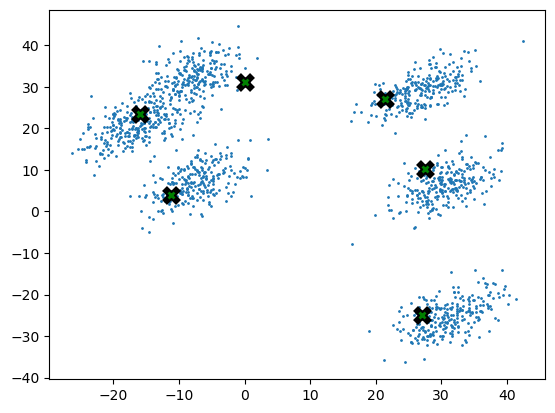

In [25]:
plot(X,v)

# Animation

In [27]:
def do_one(d, X,ax):
	cluster_assigment = [] if not d  else kmeans_update_vector(X, v)
	ax.clear()
	plot(X,v,cluster_assigment,ax)


In [76]:
from matplotlib.animation import PillowWriter
# create your own animation
X = data.clone().cpu()
fig,ax = plt.subplots()
v = kmeans_plus_plus_init_vector(X, k)
ani = FuncAnimation(fig, partial(do_one, X=X, ax=ax), frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())


In [ ]:
ani.save("kmeans_animation.gif", writer=PillowWriter(fps=2))

# Benchmark

### sklearn

In [48]:
from sklearn.cluster import KMeans


In [49]:
X = data.clone()

In [50]:
%timeit km = KMeans(6, max_iter=5, tol=0).fit_predict(X.cpu())

2.13 ms ± 182 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
km = KMeans(6, max_iter=5, tol=0)
km.fit_predict(X.cpu())

array([3, 3, 3, ..., 4, 4, 4], shape=(1500,), dtype=int32)

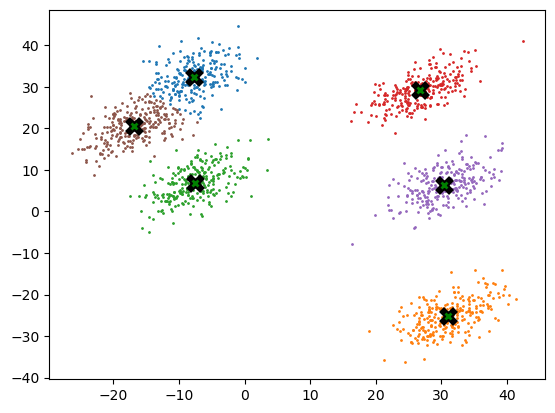

In [53]:
plot(X.cpu(), torch.from_numpy(km.cluster_centers_),torch.from_numpy(km.labels_))

### own implementation

In [54]:
X = data.clone()

In [55]:
device = 'cpu'
X = X.cpu()

In [56]:
def kmeans(X,k, niter=5):
	v = kmeans_plus_plus_init_vector(X, k)
	for _ in range(niter):
		c = kmeans_update_vector(X,v)
	return v,c

In [57]:
%timeit -n 10 v, cluster_assigment = kmeans(X, k)

3.58 ms ± 269 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
device = 'cuda'
X = X.cuda()

In [59]:
%timeit -n 10 v, cluster_assigment = kmeans(X, k)

6.65 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


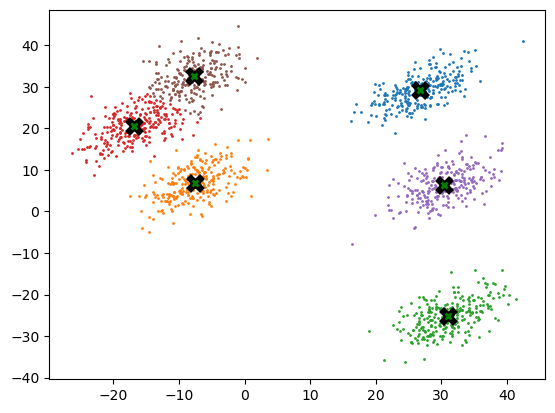

In [60]:
plot(X.cpu(),v.cpu(),cluster_assigment.cpu() )

### scaled data sklearn

In [61]:
n_samples = 100000
def sample(m): return MultivariateNormal(m, torch.tensor([[15.,7.5],[7.5,15.]])).sample((n_samples,))
centroids = torch.rand(n_clusters, 2)*70-35
slices = [sample(c) for c in centroids]
data_big = torch.cat(slices)
data_big.shape

torch.Size([600000, 2])

In [62]:
X = data_big.clone()

In [73]:
%timeit -n 10 km = KMeans(6).fit_predict(X.cpu())

208 ms ± 7.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
km = KMeans(6)
km.fit_predict(X)


array([3, 3, 3, ..., 4, 4, 4], shape=(600000,), dtype=int32)

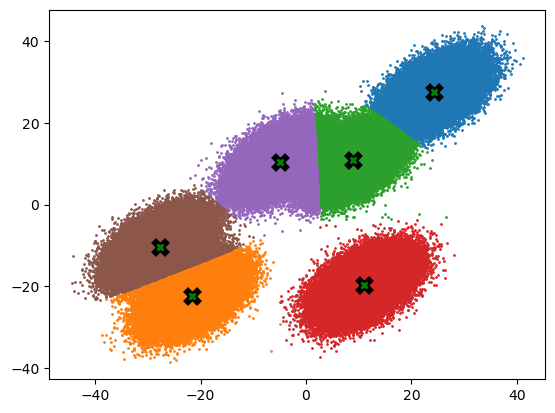

In [65]:
plot(X.cpu(), torch.from_numpy(km.cluster_centers_),torch.from_numpy(km.labels_))

### scaled data own 

In [69]:
X = data_big.clone()

In [72]:
%timeit -n 10 kmeans(X, k)

348 ms ± 8.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [70]:
v, cluster_assigment = kmeans(X, k)

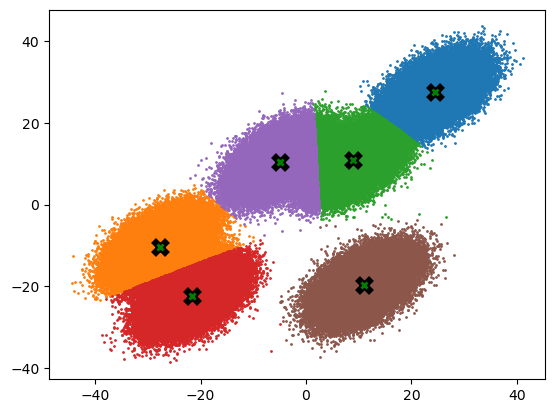

In [71]:
plot(X.cpu(),v.cpu(),cluster_assigment.cpu() )

# Conclustion

PyTorch is slower than scikit-learn, as expected. But overall, the performance comes quite close to the established scikit-learn implementation — which was the goal. So, a small win :)